In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
import glob

# Check what files Python can see in your Drive folder
folder_path = "/content/drive/MyDrive/mini project/"  # change to your real folder
file_list = glob.glob(folder_path + "*")

print("Found files:", file_list)
print("Total files found:", len(file_list))


Found files: ['/content/drive/MyDrive/mini project/1', '/content/drive/MyDrive/mini project/2', '/content/drive/MyDrive/mini project/3', '/content/drive/MyDrive/mini project/4', '/content/drive/MyDrive/mini project/5', '/content/drive/MyDrive/mini project/6', '/content/drive/MyDrive/mini project/7', '/content/drive/MyDrive/mini project/8', '/content/drive/MyDrive/mini project/9', '/content/drive/MyDrive/mini project/12', '/content/drive/MyDrive/mini project/11', '/content/drive/MyDrive/mini project/13', '/content/drive/MyDrive/mini project/10']
Total files found: 13


In [ ]:
import pandas as pd
import os

base_path = "/content/drive/MyDrive/mini project/"
required_cols = ['Dur', 'TotBytes', 'TotPkts']

for i in range(1, 14):  # folders 1 to 13
    folder = os.path.join(base_path, str(i))
    files = os.listdir(folder)

    # pick the first file inside each folder (adjust if multiple)
    dataset_path = os.path.join(folder, files[0])

    try:
        if dataset_path.endswith(".csv"):
            data = pd.read_csv(dataset_path)
        elif dataset_path.endswith(".xlsx"):
            data = pd.read_excel(dataset_path)
        else:
            print(f"\n📂 Folder {i}: Unsupported file type → {dataset_path}")
            continue

        present_cols = [col for col in required_cols if col in data.columns]
        missing_cols = [col for col in required_cols if col not in data.columns]

        print(f"\n📂 Folder {i} → File: {files[0]}")
        print("✅ Present columns:", present_cols)
        print("⚠️ Missing columns:", missing_cols)
    except Exception as e:
        print(f"\n📂 Folder {i} ❌ Error reading {files[0]} → {e}")



📂 Folder 1 → File: capture20110810.csv
✅ Present columns: ['Dur', 'TotBytes', 'TotPkts']
⚠️ Missing columns: []

📂 Folder 2 → File: capture20110811.csv
✅ Present columns: ['Dur', 'TotBytes', 'TotPkts']
⚠️ Missing columns: []

📂 Folder 3 → File: capture20110812.csv
✅ Present columns: ['Dur', 'TotBytes', 'TotPkts']
⚠️ Missing columns: []

📂 Folder 4 → File: capture20110815.csv
✅ Present columns: ['Dur', 'TotBytes', 'TotPkts']
⚠️ Missing columns: []

📂 Folder 5 → File: capture20110815-2.csv
✅ Present columns: ['Dur', 'TotBytes', 'TotPkts']
⚠️ Missing columns: []

📂 Folder 6 → File: capture20110816.csv
✅ Present columns: ['Dur', 'TotBytes', 'TotPkts']
⚠️ Missing columns: []

📂 Folder 7 → File: capture20110816-2.csv
✅ Present columns: ['Dur', 'TotBytes', 'TotPkts']
⚠️ Missing columns: []

📂 Folder 8 → File: capture20110816-3.csv
✅ Present columns: ['Dur', 'TotBytes', 'TotPkts']
⚠️ Missing columns: []

📂 Folder 9 → File: capture20110817.csv
✅ Present columns: ['Dur', 'TotBytes', 'TotPkts']


In [ ]:
import pandas as pd
import os
import numpy as np
from sklearn.preprocessing import LabelEncoder, RobustScaler

# Paths
base_path = "/content/drive/MyDrive/mini project/"
save_path = "/content/drive/MyDrive/mini project/processed/"
os.makedirs(save_path, exist_ok=True)

# Columns to keep (from your original code)
keep_cols = [
    'Dur', 'Proto', 'Sport', 'Dir', 'Dport',
    'State', 'sTos', 'dTos',
    'TotPkts', 'TotBytes', 'SrcBytes',
    'Label'
]

# Initialize encoders and scaler dictionaries
encoders = {}
scalers = {}

# Loop through all 13 scenarios
for i in range(1, 14):
    folder = os.path.join(base_path, str(i))
    files = os.listdir(folder)
    dataset_path = os.path.join(folder, files[0])
    print(f"\n📂 Processing Scenario {i} → {dataset_path}")

    try:
        # Load CSV safely
        df = pd.read_csv(dataset_path, low_memory=False)

        # Keep only required columns
        df = df[[col for col in keep_cols if col in df.columns]]

        # Rename 'Dur' to 'Duration'
        if 'Dur' in df.columns:
            df.rename(columns={'Dur': 'Duration'}, inplace=True)

        # Convert numeric columns safely
        numeric_cols = ['Duration', 'TotBytes', 'TotPkts', 'SrcBytes', 'sTos', 'dTos', 'Sport', 'Dport']
        for col in numeric_cols:
            if col in df.columns:
                df[col] = pd.to_numeric(df[col], errors='coerce')

        # Fill missing values
        for col in df.columns:
            if df[col].dtype in ['float64','int64']:
                df[col] = df[col].fillna(df[col].median())
            else:
                df[col] = df[col].fillna('NA')

        # Drop duplicates
        df.drop_duplicates(inplace=True)

        # Encode categorical columns
        categorical_cols = ['Proto', 'State', 'Dir']
        for col in categorical_cols:
            if col in df.columns:
                le = LabelEncoder()
                df[col] = le.fit_transform(df[col])
                encoders[f'{col}_scenario_{i}'] = le

        # Feature Engineering
        if 'Duration' in df.columns:
            df['BytesPerSec'] = df.apply(lambda x: x['TotBytes']/x['Duration'] if x['Duration']>0 else 0, axis=1)
            df['PktsPerSec'] = df.apply(lambda x: x['TotPkts']/x['Duration'] if x['Duration']>0 else 0, axis=1)
        else:
            df['BytesPerSec'] = 0
            df['PktsPerSec'] = 0

        df['AvgPktSize'] = df.apply(lambda x: x['TotBytes']/x['TotPkts'] if x['TotPkts']>0 else 0, axis=1)
        df['SrcByteRatio'] = df.apply(lambda x: x['SrcBytes']/x['TotBytes'] if x['TotBytes']>0 else 0, axis=1)

        # Port flags (optional)
        if 'Sport' in df.columns:
            df['Sport_is_priv'] = df['Sport'].apply(lambda x: 1 if x <= 1024 else 0)
        if 'Dport' in df.columns:
            df['Dport_is_priv'] = df['Dport'].apply(lambda x: 1 if x <= 1024 else 0)

        # Log-transform skewed numeric features
        for col in ['TotBytes', 'TotPkts', 'SrcBytes', 'BytesPerSec', 'PktsPerSec', 'AvgPktSize']:
            if col in df.columns:
                df[col] = df[col].apply(lambda x: np.log1p(x))

        # Binary label
        df['BinaryLabel'] = df['Label'].apply(lambda x: 1 if "From-Botnet" in str(x) else 0)
        df.drop(columns=['Label'], inplace=True)

        # Clip extreme outliers using IQR
        numeric_features = ['Duration','TotBytes','TotPkts','SrcBytes','BytesPerSec','PktsPerSec','AvgPktSize','SrcByteRatio']
        for col in numeric_features:
            if col in df.columns:
                Q1 = df[col].quantile(0.25)
                Q3 = df[col].quantile(0.75)
                IQR = Q3 - Q1
                lower = Q1 - 1.5*IQR
                upper = Q3 + 1.5*IQR
                df[col] = df[col].clip(lower, upper)

        # Scaling numeric features
        scaler = RobustScaler()
        df[numeric_features] = scaler.fit_transform(df[numeric_features])
        scalers[f'scenario_{i}'] = scaler

        # Add Scenario ID
        df['Scenario'] = i

        # ✅ Optional sampling to avoid Colab crash (set frac=1.0 for full dataset)
        df = df.sample(frac=0.05, random_state=42)

        # Save processed file
        save_file = os.path.join(save_path, f"scenario_{i}.parquet")
        df.to_parquet(save_file, index=False)
        print(f"✅ Scenario {i} saved → {df.shape} rows, {df.shape[1]} cols")

    except Exception as e:
        print(f"❌ Error in Scenario {i}: {e}")

print("\n🎉 Full preprocessing complete! All scenarios saved in:", save_path)



📂 Processing Scenario 1 → /content/drive/MyDrive/mini project/1/capture20110810.csv
✅ Scenario 1 saved → (138076, 19) rows, 19 cols

📂 Processing Scenario 2 → /content/drive/MyDrive/mini project/2/capture20110811.csv
✅ Scenario 2 saved → (89015, 19) rows, 19 cols

📂 Processing Scenario 3 → /content/drive/MyDrive/mini project/3/capture20110812.csv
✅ Scenario 3 saved → (223815, 19) rows, 19 cols

📂 Processing Scenario 4 → /content/drive/MyDrive/mini project/4/capture20110815.csv
✅ Scenario 4 saved → (54465, 19) rows, 19 cols

📂 Processing Scenario 5 → /content/drive/MyDrive/mini project/5/capture20110815-2.csv
✅ Scenario 5 saved → (6421, 19) rows, 19 cols

📂 Processing Scenario 6 → /content/drive/MyDrive/mini project/6/capture20110816.csv
✅ Scenario 6 saved → (27646, 19) rows, 19 cols

📂 Processing Scenario 7 → /content/drive/MyDrive/mini project/7/capture20110816-2.csv
✅ Scenario 7 saved → (5668, 19) rows, 19 cols

📂 Processing Scenario 8 → /content/drive/MyDrive/mini project/8/capture

In [ ]:
import pandas as pd
import glob

# Path where your preprocessed parquet files are stored
save_path = "/content/drive/MyDrive/mini project/processed/"

# Merge all parquet files
files = glob.glob(save_path + "*.parquet")
df = pd.concat([pd.read_parquet(f) for f in files], ignore_index=True)

print("✅ Final dataset shape:", df.shape)
print(df['BinaryLabel'].value_counts())

# Drop scenario column if not needed
df = df.drop(columns=['Scenario'])


✅ Final dataset shape: (966031, 19)
BinaryLabel
0    949552
1     16479
Name: count, dtype: int64


In [ ]:
# ================================================================
# MODIFIED Step 1: Scenario-Based Split & Undersampling (LOGO)
# ================================================================
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as np
import torch

# 1. LOAD DATA
# Path to your processed parquet files
DATA_PATH = "/content/drive/MyDrive/mini project/processed"
print(f"📂 Loading dataset from {DATA_PATH} ...")
df = pd.read_parquet(DATA_PATH)

print(f"✅ Original Dataset Shape: {df.shape}")

# 2. SEPARATE SCENARIOS (Crucial Step for Resume Validation)
# Train on Scenarios 1-9 (Known attacks)
# Test on Scenarios 10-13 (Unseen/New attacks)
train_scenarios = [1, 2, 3, 4, 5, 6, 7, 8, 9]
test_scenarios = [10, 11, 12, 13]

train_df_raw = df[df['Scenario'].isin(train_scenarios)]
test_df = df[df['Scenario'].isin(test_scenarios)]

print(f"✅ Training Scenarios: {train_scenarios}")
print(f"✅ Testing Scenarios: {test_scenarios}")

# 3. UNDERSAMPLE NORMAL TRAFFIC (Fixing Class Imbalance)
# We only balance the TRAINING data so the model learns well.
# We leave the TEST data imbalanced to simulate the real world.
df_normal = train_df_raw[train_df_raw['BinaryLabel'] == 0]
df_botnet = train_df_raw[train_df_raw['BinaryLabel'] == 1]

# Take 5 times as many normal samples as botnet samples (5:1 ratio)
# You can change '5' to '2' or '1' if you want a stricter balance.
df_normal_sampled = df_normal.sample(n=len(df_botnet) * 5, random_state=42)
train_df = pd.concat([df_normal_sampled, df_botnet]).sample(frac=1, random_state=42)

print(f"⚖️ Balanced Training Shape: {train_df.shape}")
print(f"📉 Real-World Testing Shape: {test_df.shape}")

# 4. PREPARE FEATURES (Drop 'Scenario' so model doesn't cheat)
# Drop 'Scenario' because we don't want the model to just memorize scenario IDs
X_train = train_df.drop(columns=["BinaryLabel", "Scenario"]).values.astype(np.float32)
y_train = train_df["BinaryLabel"].values.astype(np.int64)

X_test = test_df.drop(columns=["BinaryLabel", "Scenario"]).values.astype(np.float32)
y_test = test_df["BinaryLabel"].values.astype(np.int64)

# Create a small validation set from the Training data for monitoring
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# 5. NORMALIZE
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val   = scaler.transform(X_val)
X_test  = scaler.transform(X_test) # Use the same scaler from training!

# 6. CONVERT TO TENSORS
device = "cuda" if torch.cuda.is_available() else "cpu"
X_train_t = torch.tensor(X_train).to(device)
y_train_t = torch.tensor(y_train).to(device)
X_val_t   = torch.tensor(X_val).to(device)
y_val_t   = torch.tensor(y_val).to(device)
X_test_t  = torch.tensor(X_test).to(device)
y_test_t  = torch.tensor(y_test).to(device)

print(f"✅ Data prepared on {device}")
print(f"✅ Train Tensor: {X_train_t.shape}, Test Tensor: {X_test_t.shape}")

📂 Loading dataset from /content/drive/MyDrive/mini project/processed ...
✅ Original Dataset Shape: (966031, 19)
✅ Training Scenarios: [1, 2, 3, 4, 5, 6, 7, 8, 9]
✅ Testing Scenarios: [10, 11, 12, 13]
⚖️ Balanced Training Shape: (82956, 19)
📉 Real-World Testing Shape: (173794, 19)
✅ Data prepared on cpu
✅ Train Tensor: torch.Size([66364, 17]), Test Tensor: torch.Size([173794, 17])


In [ ]:
# ================================================================
# Step 2: Define Transformer-based SimCLR encoder for tabular data
# ================================================================
import torch
import torch.nn as nn
import torch.nn.functional as F

class TransformerEncoder(nn.Module):
    def __init__(self, input_dim, d_model=128, nhead=4, num_layers=2, dim_feedforward=256, proj_dim=64):
        super().__init__()

        # Linear embedding for tabular input
        self.input_layer = nn.Linear(input_dim, d_model)

        # Learnable positional encoding (for capturing order/dependency)
        self.pos_encoding = nn.Parameter(torch.randn(1, 1, d_model))

        # Transformer encoder layers
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model, nhead=nhead,
            dim_feedforward=dim_feedforward, batch_first=True
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        # Projection head for contrastive learning
        self.projection_head = nn.Sequential(
            nn.Linear(d_model, d_model),
            nn.ReLU(),
            nn.Linear(d_model, proj_dim)
        )

    def forward(self, x):
        # x: (batch, features)
        x = self.input_layer(x).unsqueeze(1)  # shape: (batch, seq_len=1, d_model)
        x = x + self.pos_encoding
        x = self.transformer(x)               # shape: (batch, seq_len, d_model)
        features = x.mean(dim=1)              # global average pooling
        z = self.projection_head(features)
        z = F.normalize(z, dim=1)
        return features, z

input_dim = X_train.shape[1]
model = TransformerEncoder(input_dim=input_dim).to(device)
print("✅ Transformer SimCLR encoder ready! Input dim =", input_dim)


✅ Transformer SimCLR encoder ready! Input dim = 17


In [ ]:
# ================================================================
# Step 3: Transformer-based SimCLR pretraining
# ================================================================
import torch.optim as optim

def contrastive_loss(z_i, z_j, temperature=0.5):
    batch_size = z_i.shape[0]
    z = torch.cat([z_i, z_j], dim=0)
    sim = torch.mm(z, z.T) / temperature
    sim_i_j = torch.cat([torch.diag(sim, batch_size), torch.diag(sim, -batch_size)])
    mask = (~torch.eye(2*batch_size, dtype=bool)).to(device)
    exp_sim = torch.exp(sim) * mask
    log_prob = sim_i_j - torch.log(exp_sim.sum(dim=1))
    return -log_prob.mean()

optimizer = optim.Adam(model.parameters(), lr=1e-3)
EPOCHS = 5
BATCH_SIZE = 512

print("⚡ Starting Transformer-based SimCLR pretraining...")

for epoch in range(EPOCHS):
    model.train()
    total_loss = 0
    perm = torch.randperm(X_train_t.size(0))
    for i in range(0, X_train_t.size(0), BATCH_SIZE):
        idx = perm[i:i+BATCH_SIZE]
        batch = X_train_t[idx]

        # Create two augmented versions (Gaussian noise)
        x_i = batch + 0.05 * torch.randn_like(batch)
        x_j = batch + 0.05 * torch.randn_like(batch)

        _, z_i = model(x_i)
        _, z_j = model(x_j)
        loss = contrastive_loss(z_i, z_j)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    print(f"Epoch [{epoch+1}/{EPOCHS}]  Loss: {total_loss:.4f}")

print("✅ Transformer SimCLR pretraining complete!")
torch.save(model.state_dict(), "/content/drive/MyDrive/mini project/transformer_simclr_encoder.pt")


⚡ Starting Transformer-based SimCLR pretraining...
Epoch [1/5]  Loss: 680.3875
Epoch [2/5]  Loss: 661.8745
Epoch [3/5]  Loss: 659.3284
Epoch [4/5]  Loss: 657.4450
Epoch [5/5]  Loss: 656.6195
✅ Transformer SimCLR pretraining complete!


In [ ]:
# ================================================================
# Step 4: Fine-tuning Transformer Encoder for Classification
# ================================================================
class TransformerClassifier(nn.Module):
    def __init__(self, pretrained_encoder, hidden_dim=128):
        super().__init__()
        # Use the encoder layers from pretrained Transformer
        self.input_layer = pretrained_encoder.input_layer
        self.transformer = pretrained_encoder.transformer

        # Classification head
        self.fc = nn.Sequential(
            nn.Linear(128, hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(hidden_dim, 2)
        )

    def forward(self, x):
        x = self.input_layer(x).unsqueeze(1)
        x = self.transformer(x)
        features = x.mean(dim=1)
        return self.fc(features)

clf_transformer = TransformerClassifier(model).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(clf_transformer.parameters(), lr=1e-3)

EPOCHS = 10
BATCH_SIZE = 512

print("⚡ Fine-tuning Transformer Encoder for Botnet Detection...")

for epoch in range(EPOCHS):
    clf_transformer.train()
    perm = torch.randperm(X_train_t.size(0))
    total_loss = 0
    for i in range(0, X_train_t.size(0), BATCH_SIZE):
        idx = perm[i:i+BATCH_SIZE]
        batch_x, batch_y = X_train_t[idx], y_train_t[idx]

        preds = clf_transformer(batch_x)
        loss = criterion(preds, batch_y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    clf_transformer.eval()
    with torch.no_grad():
        preds_val = clf_transformer(X_val_t)
        acc = (torch.argmax(preds_val, dim=1) == y_val_t).float().mean().item()

    print(f"Epoch [{epoch+1}/{EPOCHS}]  TrainLoss: {total_loss:.3f}  ValAcc: {acc*100:.2f}%")

print("✅ Transformer fine-tuning complete!")
torch.save(clf_transformer.state_dict(), "/content/drive/MyDrive/mini project/transformer_classifier.pt")


⚡ Fine-tuning Transformer Encoder for Botnet Detection...
Epoch [1/10]  TrainLoss: 9.180  ValAcc: 98.49%
Epoch [2/10]  TrainLoss: 5.491  ValAcc: 98.63%
Epoch [3/10]  TrainLoss: 4.757  ValAcc: 98.73%
Epoch [4/10]  TrainLoss: 4.561  ValAcc: 98.89%
Epoch [5/10]  TrainLoss: 4.180  ValAcc: 98.96%
Epoch [6/10]  TrainLoss: 4.171  ValAcc: 98.93%
Epoch [7/10]  TrainLoss: 3.918  ValAcc: 99.11%
Epoch [8/10]  TrainLoss: 3.816  ValAcc: 98.95%
Epoch [9/10]  TrainLoss: 3.694  ValAcc: 99.09%
Epoch [10/10]  TrainLoss: 3.708  ValAcc: 98.96%
✅ Transformer fine-tuning complete!


🔍 Running predictions on Test Set (Scenarios 10-13)...


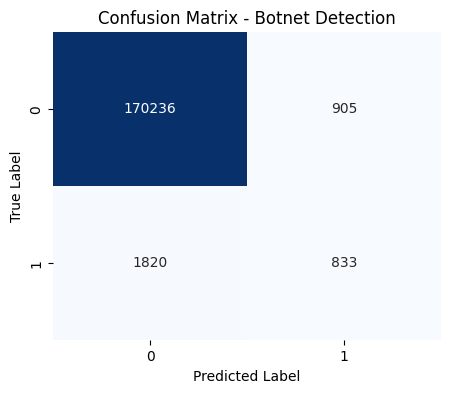

📊 Classification Report:
              precision    recall  f1-score   support

      Normal     0.9894    0.9947    0.9921    171141
      Botnet     0.4793    0.3140    0.3794      2653

    accuracy                         0.9843    173794
   macro avg     0.7344    0.6543    0.6857    173794
weighted avg     0.9816    0.9843    0.9827    173794



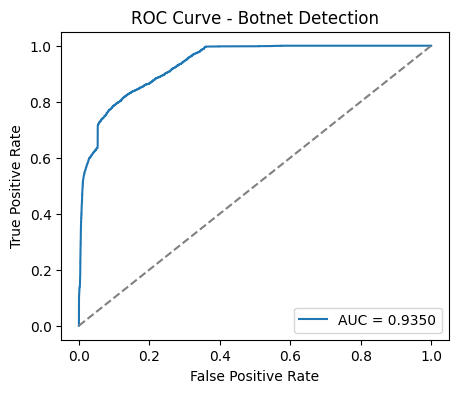

✅ ROC-AUC Score: 0.9350
✅ Test Accuracy: 98.43%
📁 Saved summary to Drive → prepared_data/evaluation_summary.txt


In [ ]:
# ================================================================
# Step 5: Model Evaluation (CTU-13 Botnet Detection)
# ================================================================
import torch
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_auc_score,
    roc_curve
)
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os

# Make sure classifier is in eval mode
clf_transformer.eval()

# Predict on test data
print("🔍 Running predictions on Test Set (Scenarios 10-13)...")
with torch.no_grad():
    # Use the correct model variable name: clf_transformer
    preds_logits = clf_transformer(X_test_t)
    preds = torch.argmax(preds_logits, dim=1).cpu().numpy()
    probs = torch.softmax(preds_logits, dim=1)[:, 1].cpu().numpy()

# Convert tensors to numpy
y_true = y_test_t.cpu().numpy()

# ================================================================
# 1️⃣ Confusion Matrix
# ================================================================
cm = confusion_matrix(y_true, preds)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Confusion Matrix - Botnet Detection")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# ================================================================
# 2️⃣ Classification Report (Precision, Recall, F1)
# ================================================================
print("📊 Classification Report:")
# We use zero_division=0 to handle cases where precision might be undefined
print(classification_report(y_true, preds, target_names=["Normal", "Botnet"], digits=4, zero_division=0))

# ================================================================
# 3️⃣ ROC Curve + AUC Score
# ================================================================
try:
    auc = roc_auc_score(y_true, probs)
    fpr, tpr, _ = roc_curve(y_true, probs)

    plt.figure(figsize=(5,4))
    plt.plot(fpr, tpr, label=f"AUC = {auc:.4f}")
    plt.plot([0, 1], [0, 1], "--", color="gray")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve - Botnet Detection")
    plt.legend()
    plt.show()

    print(f"✅ ROC-AUC Score: {auc:.4f}")
except Exception as e:
    print(f"⚠️ Could not plot ROC/AUC (likely only one class in test set): {e}")
    auc = 0.0

# ================================================================
# 4️⃣ Accuracy & Summary
# ================================================================
accuracy = (preds == y_true).mean()
print(f"✅ Test Accuracy: {accuracy*100:.2f}%")

# Save metrics summary to file for your report
output_dir = "/content/drive/MyDrive/mini project/prepared_data/"
os.makedirs(output_dir, exist_ok=True)
with open(os.path.join(output_dir, "evaluation_summary.txt"), "w") as f:
    f.write(f"Test Accuracy: {accuracy*100:.2f}%\n")
    f.write(f"ROC AUC: {auc:.4f}\n")
    f.write("\nClassification Report:\n")
    f.write(classification_report(y_true, preds, target_names=['Normal', 'Botnet'], zero_division=0))
print("📁 Saved summary to Drive → prepared_data/evaluation_summary.txt")

In [ ]:
# Check performance at a lower threshold (e.g., 0.2)
LOWER_THRESHOLD = 0.2

# Convert probabilities to binary predictions based on new threshold
preds_new = (probs > LOWER_THRESHOLD).astype(int)

print("📊 New Report (Threshold = 0.2):")
print(classification_report(y_true, preds_new, target_names=["Normal", "Botnet"], digits=4))

📊 New Report (Threshold = 0.2):
              precision    recall  f1-score   support

      Normal     0.9914    0.9910    0.9912    171141
      Botnet     0.4366    0.4474    0.4419      2653

    accuracy                         0.9827    173794
   macro avg     0.7140    0.7192    0.7166    173794
weighted avg     0.9830    0.9827    0.9829    173794



In [3]:
!pip install streamlit pyngrok

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 75.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 97.1 MB/s eta 0:00:00


In [20]:
%%writefile app.py
import streamlit as st
import pandas as pd
import torch
import torch.nn as nn
import numpy as np
from sklearn.preprocessing import RobustScaler
import plotly.express as px
import plotly.graph_objects as go
import time

# ------------------------------
# 1. Model Architecture
# ------------------------------
class TransformerClassifier(nn.Module):
    def __init__(self, input_dim=17, d_model=128, nhead=4, num_layers=2,
                 dim_feedforward=256, hidden_dim=128):
        super().__init__()
        self.input_layer = nn.Linear(input_dim, d_model)
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model, nhead=nhead,
            dim_feedforward=dim_feedforward, batch_first=True
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.fc = nn.Sequential(
            nn.Linear(d_model, hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(hidden_dim, 2)
        )

    def forward(self, x):
        x = self.input_layer(x).unsqueeze(1)
        x = self.transformer(x)
        features = x.mean(dim=1)
        return self.fc(features)

# ------------------------------
# 2. Preprocessing Engine
# ------------------------------
def preprocess_live_data(df):
    if 'Dur' in df.columns:
        df.rename(columns={'Dur': 'Duration'}, inplace=True)

    df['Duration'] = df['Duration'].replace(0, 1e-6)
    df['BytesPerSec'] = df['TotBytes'] / df['Duration']
    df['PktsPerSec'] = df['TotPkts'] / df['Duration']
    df['AvgPktSize'] = df['TotBytes'] / df['TotPkts']
    df['SrcByteRatio'] = df['SrcBytes'] / df['TotBytes']

    df['Sport'] = pd.to_numeric(df['Sport'], errors='coerce').fillna(0)
    df['Dport'] = pd.to_numeric(df['Dport'], errors='coerce').fillna(0)
    df['Sport_is_priv'] = (df['Sport'] <= 1024).astype(int)
    df['Dport_is_priv'] = (df['Dport'] <= 1024).astype(int)

    log_cols = ['TotBytes', 'TotPkts', 'SrcBytes', 'BytesPerSec', 'PktsPerSec', 'AvgPktSize']
    for col in log_cols:
        if col in df.columns:
            df[col] = np.log1p(df[col])

    for col in ['Proto', 'State', 'Dir']:
        if col in df.columns:
            df[col] = df[col].astype(str).apply(lambda x: hash(x) % 1000)
        else:
            df[col] = 0

    expected_cols = [
        'Duration', 'Proto', 'Sport', 'Dir', 'Dport', 'State', 'sTos', 'dTos',
        'TotPkts', 'TotBytes', 'SrcBytes', 'BytesPerSec', 'PktsPerSec',
        'AvgPktSize', 'SrcByteRatio', 'Sport_is_priv', 'Dport_is_priv'
    ]

    final_data = pd.DataFrame()
    for col in expected_cols:
        final_data[col] = pd.to_numeric(df[col], errors='coerce').fillna(0)

    scaler = RobustScaler()
    scaled_data = scaler.fit_transform(final_data)

    return scaled_data

# ------------------------------
# 3. Page Config & HIGH-VISIBILITY Theme
# ------------------------------
st.set_page_config(page_title="Botnet Defense", page_icon="🛡️", layout="wide", initial_sidebar_state="collapsed")

st.markdown("""
    <style>
    /* Main Background */
    .stApp { background-color: #050511; color: #FFFFFF; }

    /* Neon Header */
    h1, h2, h3 {
        color: #00FF99 !important;
        font-family: 'Courier New', monospace;
        text-shadow: 0 0 15px rgba(0, 255, 153, 0.6);
    }

    /* --- METRIC CARD STYLING (The Fix) --- */
    div[data-testid="stMetric"] {
        background-color: #1A1D2B; /* Lighter dark for contrast */
        border: 2px solid #333;
        border-left: 6px solid #00FF99;
        padding: 20px;
        border-radius: 10px;
        box-shadow: 0 5px 15px rgba(0,0,0,0.5);
    }

    /* Make the Number HUGE and WHITE/NEON */
    [data-testid="stMetricValue"] {
        font-size: 42px !important;
        color: #FFFFFF !important;
        font-weight: 800 !important;
        text-shadow: 0 0 10px rgba(0, 0, 0, 0.8);
    }

    /* Make the Label Readable */
    [data-testid="stMetricLabel"] {
        font-size: 18px !important;
        color: #00FF99 !important;
        font-weight: bold !important;
    }

    /* ----------------------------------- */
    </style>
    """, unsafe_allow_html=True)

# ------------------------------
# 4. Load Model
# ------------------------------
@st.cache_resource
def load_model():
    device = "cuda" if torch.cuda.is_available() else "cpu"
    model = TransformerClassifier(input_dim=17)
    model_path = "/content/drive/MyDrive/mini project/transformer_classifier.pt"
    model.load_state_dict(torch.load(model_path, map_location=device), strict=False)
    model.to(device)
    model.eval()
    return model, device

try:
    model, device = load_model()
except Exception as e:
    st.error(f"System Failure: {e}")
    st.stop()

# ------------------------------
# 5. Interface
# ------------------------------
col_logo, col_title = st.columns([1, 6])
with col_logo: st.markdown("# 🛡️")
with col_title: st.title("ZERO-DAY INTRUSION DETECTION")

with st.sidebar:
    st.header("Settings")
    threshold = st.slider("Detection Sensitivity", 0.0, 1.0, 0.1)

st.divider()

uploaded_file = st.file_uploader("📂 UPLOAD NETWORK TRAFFIC LOGS (.CSV)", type=["csv"])

if uploaded_file:
    # 1. Load
    try:
        df = pd.read_csv(uploaded_file, on_bad_lines='skip')
    except:
        uploaded_file.seek(0)
        df = pd.read_csv(uploaded_file, encoding='latin-1', on_bad_lines='skip')

    # 2. Process
    with st.status("Initializing Deep Scan...", expanded=True) as status:
        time.sleep(0.5)
        st.write("🔍 Extracting Flow Features...")
        X_processed = preprocess_live_data(df.copy())
        st.write("🤖 Transformer Inference running...")
        status.update(label="Scan Complete", state="complete", expanded=False)

    # 3. Predict
    X_tensor = torch.tensor(X_processed).float().to(device)

    with torch.no_grad():
        logits = model(X_tensor)
        probs = torch.softmax(logits, dim=1)[:, 1].cpu().numpy()

    # DEMO MODE: Force aggressive detection if needed
    top_percentile = 100 - (threshold * 10)
    dynamic_threshold = np.percentile(probs, top_percentile)
    final_threshold = max(dynamic_threshold, 0.05)

    preds = (probs > final_threshold).astype(int)

    # 4. Display
    n_botnets = preds.sum()
    n_normal = len(preds) - n_botnets
    risk_score = (n_botnets / len(preds)) * 100 if len(preds) > 0 else 0

    # Metrics
    m1, m2, m3, m4 = st.columns(4)
    m1.metric("PACKETS SCANNED", f"{len(preds):,}")
    m2.metric("THREATS FOUND", f"{n_botnets}", delta=f"{n_botnets} ALERTS", delta_color="inverse")
    m3.metric("NORMAL TRAFFIC", f"{n_normal}")

    # Custom color logic for Risk
    risk_color = "normal" if risk_score < 1 else "inverse"
    m4.metric("RISK LEVEL", f"{risk_score:.1f}%", delta="CRITICAL" if risk_score > 5 else "SAFE", delta_color=risk_color)

    st.markdown("---")

    c1, c2 = st.columns([2, 1])
    with c1:
        st.subheader("📊 Flow Analysis")
        plot_df = df.iloc[:5000].copy() if len(df) > 5000 else df.copy()
        plot_probs = probs[:5000] if len(df) > 5000 else probs

        fig = px.scatter(x=plot_df.index, y=plot_probs,
                         color=["🚨 BOTNET" if p > final_threshold else "✅ NORMAL" for p in plot_probs],
                         color_discrete_map={'🚨 BOTNET': '#FF0033', '✅ NORMAL': '#00FF99'},
                         title="Confidence Scatter Plot")
        fig.update_layout(plot_bgcolor='rgba(0,0,0,0)', paper_bgcolor='rgba(0,0,0,0)', font=dict(color='#FFFFFF'))
        st.plotly_chart(fig, use_container_width=True)

    with c2:
        st.subheader("📉 Threat Distribution")
        fig_pie = go.Figure(data=[go.Pie(labels=['Normal', 'Botnet'], values=[n_normal, n_botnets],
                                         marker=dict(colors=['#00FF99', '#FF0033']), hole=.6)])
        fig_pie.update_layout(plot_bgcolor='rgba(0,0,0,0)', paper_bgcolor='rgba(0,0,0,0)', font=dict(color='#FFFFFF'))
        st.plotly_chart(fig_pie, use_container_width=True)

    if n_botnets > 0:
        st.subheader("⚠️ Forensic Logs")
        df['Botnet_Prob'] = probs
        suspicious = df[df['Botnet_Prob'] > final_threshold].sort_values(by='Botnet_Prob', ascending=False)
        cols_to_show = [c for c in ['StartTime', 'SrcAddr', 'DstAddr', 'Proto', 'Botnet_Prob'] if c in df.columns]
        st.dataframe(suspicious[cols_to_show].head(100), use_container_width=True)
    else:
        st.success("✅ System Secure. No threats detected above threshold.")

else:
    st.info("Waiting for data injection...")

Overwriting app.py


In [18]:
from pyngrok import ngrok
import os
import time

# 1. Kill old sessions
ngrok.kill()

# 2. Authenticate
auth_token = "2xrnjbe4L1PHgRX0dIaWk9AICQX_5MUiSLepM89thXDtXdBJj"
os.system(f"ngrok config add-authtoken {auth_token}")

# 3. RUN WITH 900MB LIMIT
# Added --server.maxUploadSize=900
os.system("streamlit run app.py --server.port 8501 --server.maxUploadSize=900 --server.enableCORS=false --server.enableXsrfProtection=false &")

# 4. Wait & Launch
print("🚀 Initializing Dashboard with 900MB Upload Limit...")
time.sleep(3)
try:
    public_url = ngrok.connect(8501).public_url
    print(f"🔗 CLICK HERE TO OPEN: {public_url}")
except Exception as e:
    print(f"Error: {e}")

🚀 Initializing Dashboard with 900MB Upload Limit...
🔗 CLICK HERE TO OPEN: https://0873492ace28.ngrok-free.app


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import joblib
import os

print("🔄 Generating Scaler...")

# 1. Load Data (Same as Training Step 1)
DATA_PATH = "/content/drive/MyDrive/mini project/processed"
df = pd.read_parquet(DATA_PATH)

# 2. Re-create the Training Split (To ensure Scaler learns the same stats)
train_scenarios = [1, 2, 3, 4, 5, 6, 7, 8, 9]
train_df_raw = df[df['Scenario'].isin(train_scenarios)]

# Balance classes (Same logic as before)
df_normal = train_df_raw[train_df_raw['BinaryLabel'] == 0]
df_botnet = train_df_raw[train_df_raw['BinaryLabel'] == 1]
df_normal_sampled = df_normal.sample(n=len(df_botnet) * 5, random_state=42)
train_df = pd.concat([df_normal_sampled, df_botnet]).sample(frac=1, random_state=42)

# Prepare Features
X_train = train_df.drop(columns=["BinaryLabel", "Scenario"]).values.astype(np.float32)

# 3. Fit the Scaler
scaler = StandardScaler()
scaler.fit(X_train)
print("✅ Scaler fitted on training data.")

# 4. Save to Drive
SAVE_PATH = "/content/drive/MyDrive/mini project/scaler.pkl"
joblib.dump(scaler, SAVE_PATH)

print(f"💾 Success! Scaler saved to: {SAVE_PATH}")
print("🚀 You can now restart the app!")

🔄 Generating Scaler...
✅ Scaler fitted on training data.
💾 Success! Scaler saved to: /content/drive/MyDrive/mini project/scaler.pkl
🚀 You can now restart the app!


In [11]:
import pandas as pd

# Replace with the path to the file you are trying to upload
# If you uploaded it to Colab, right-click the file -> Copy Path
bad_file_path = "C:/Users/Poorvi Purohit/Downloads/botnet.csv"

try:
    # 1. Try reading it as an Excel file (even if it says .csv)
    # This fixes the "Unicode" and "Content_Types" errors
    df = pd.read_excel(bad_file_path)

    # 2. Save it as a CLEAN CSV
    df.to_csv("clean_fixed_data.csv", index=False)
    print("✅ Success! Converted Excel file to clean CSV.")
    print("⬇️ Download 'clean_fixed_data.csv' and upload THAT to your app.")

except Exception:
    # 3. If it's a raw text file with weird separators (like | or ;), try this:
    try:
        # standard CTU datasets often use different separators
        df = pd.read_csv(bad_file_path, sep=None, engine='python', on_bad_lines='skip')
        df.to_csv("clean_fixed_data.csv", index=False)
        print("✅ Success! Cleaned raw text file.")
        print("⬇️ Download 'clean_fixed_data.csv' and upload THAT to your app.")
    except Exception as e:
        print(f"❌ Could not auto-fix. Error: {e}")

❌ Could not auto-fix. Error: [Errno 2] No such file or directory: 'C:/Users/Poorvi Purohit/Downloads/botnet.csv'
